# EDA 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-Transaction-Log" data-toc-modified-id="Read-Transaction-Log-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read Transaction Log</a></span><ul class="toc-item"><li><span><a href="#Data-Understanding" data-toc-modified-id="Data-Understanding-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Understanding</a></span></li></ul></li><li><span><a href="#Create-Calibration/Holdout-Set" data-toc-modified-id="Create-Calibration/Holdout-Set-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create Calibration/Holdout Set</a></span><ul class="toc-item"><li><span><a href="#Create-RFM-Feature-Matrix" data-toc-modified-id="Create-RFM-Feature-Matrix-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create RFM Feature Matrix</a></span></li></ul></li><li><span><a href="#Purchasing-Behaviour" data-toc-modified-id="Purchasing-Behaviour-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Purchasing Behaviour</a></span><ul class="toc-item"><li><span><a href="#Reorders" data-toc-modified-id="Reorders-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Reorders</a></span></li><li><span><a href="#Time-since-last-order" data-toc-modified-id="Time-since-last-order-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Time since last order</a></span></li><li><span><a href="#Recency-and-Frequency-Clusters" data-toc-modified-id="Recency-and-Frequency-Clusters-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Recency and Frequency Clusters</a></span></li><li><span><a href="#Average-spend-per-customer" data-toc-modified-id="Average-spend-per-customer-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Average spend per customer</a></span></li></ul></li></ul></div>

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%load_ext watermark
%watermark  -d -u -a "Created by: Anubhav Dhiman"

Created by: Anubhav Dhiman 
last updated: 2018-12-16


In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

#Let's make this notebook reproducible 
np.random.seed(42)

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Make the default figures a bit bigger
plt.rcParams['figure.figsize'] = (7,4.5) 
plt.rcParams["figure.dpi"] = 140 

sns.set(style="ticks")
sns.set_context("poster", font_scale = .7, rc={"grid.linewidth": 5})

In [5]:
flaconi = ['#DE9D8F','#BAD1CD', '#F1C2B4', '#4C4C4C', '#C6E0D4', '#D5D5D5']#, '#F6F6F6', '#83132B']
sns.set_palette(flaconi)
#sns.palplot(sns.color_palette())

## Read Transaction Log 

In [6]:
df = pd.read_fwf('data/CDNOW_master.txt', header=None,
                names = ['customer_id', 'order_date', 'units', 'sales'])


df['order_date'] = df['order_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

elog = pd.DataFrame(df.groupby(['customer_id', 'order_date'])['sales'].sum())
elog = elog.reset_index()

### Data Understanding

In [7]:
print('Number of transactions:\t', elog.shape[0])
print('Number of customers:\t', elog.customer_id.nunique())
print('Date range:\t\t', elog.order_date.min().date(), 'to', elog.order_date.max().date())

cols = ['customer_id', 'order_date', 'sales']

print('\nSample transactions:')
display(elog[cols].sample(8))

Number of transactions:	 67591
Number of customers:	 23570
Date range:		 1997-01-01 to 1998-06-30

Sample transactions:


,customer_id,order_date,sales
38326,12976,1997-07-23,5.96
59452,20578,1997-03-13,12.77
3050,951,1997-06-21,42.30
38605,13079,1997-02-16,15.76
49846,16971,1997-05-04,11.77
34350,11628,1997-02-24,43.11
61191,21239,1997-03-16,26.33
24910,8211,1998-04-20,38.75


**About the dataset**
The dataset contains the entire purchase history up to the end of June 1998 of the cohort of 23,570 individuals who made their first-ever purchase at CDNOW in the **first quarter of 1997**. This CDNOW dataset was first used by Fader and Hardie (2001).

Each record in this file, 69,659 in total, comprises three fields: the customer's ID, the date of the transaction, and the dollar value of the transaction.

Fader, Peter S. and Bruce G.,S. Hardie, (2001), "Forecasting Repeat Sales at CDNOW: A Case Study," Interfaces, 31 (May-June), Part 2 of 2, S94-S107.



## Create Calibration/Holdout Set

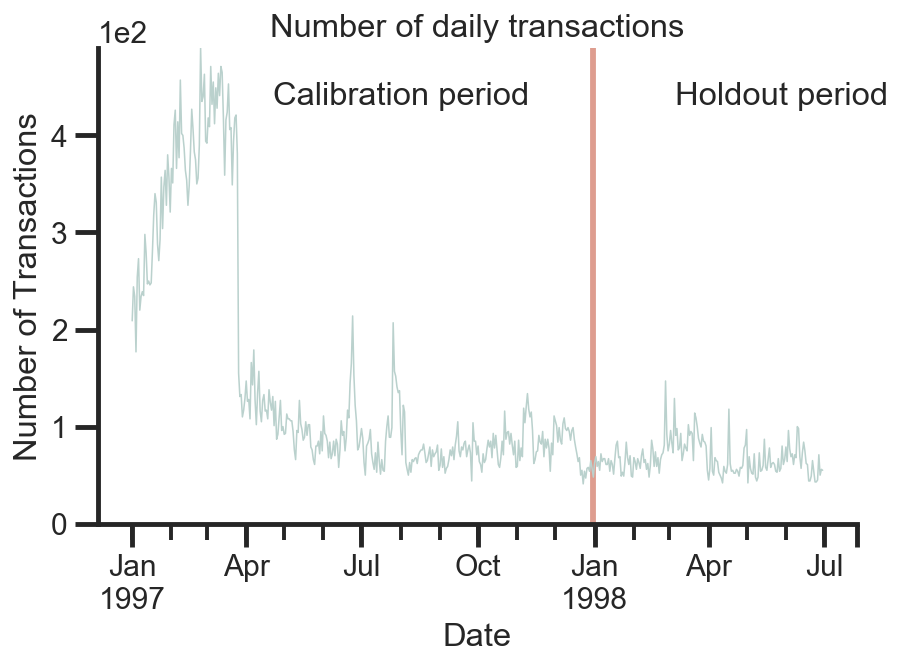

In [8]:
# Time series of the number of transactions (daily) 
#plt.rcParams['figure.figsize'] = (20, 5)

ts_transactions = elog.groupby(['order_date']).size()

calibration_period_ends = '1997-12-31'
observation_period_ends=elog.order_date.max()

from pylab import figure, text, scatter, show

f = figure()

ax = f.add_subplot(111)

ax = ts_transactions.plot(linewidth=.8, color='#BAD1CD')
plt.ylabel('Number of Transactions')
plt.xlabel('Date')
plt.title('Number of daily transactions')

ax.vlines(x=calibration_period_ends, ymin=0, ymax=ts_transactions.max(), colors='#DE9D8F')
ax.set_ylim(0, ts_transactions.max())
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

text(0.4, 0.9,'Calibration period', ha='center', va='center', transform=ax.transAxes)
text(0.9, 0.9,'Holdout period', ha='center', va='center', transform=ax.transAxes)

#ax.set_yscale('log')
sns.despine();

### Create RFM Feature Matrix

In [9]:
# Calibration set
training = elog.loc[elog.order_date <= calibration_period_ends]

training_rfm = training.groupby('customer_id').agg({"order_date": [np.count_nonzero, np.min, np.max],
                                                   "sales": [np.average]})
training_rfm.columns = training_rfm.columns.get_level_values(0)
training_rfm.columns = ['orders', 'min_order_date', 'max_order_date', 'monetary_value']

training_rfm['frequency'] = training_rfm['orders'] - 1
training_rfm['recency'] = (training_rfm['max_order_date'] - training_rfm['min_order_date']).dt.days
training_rfm['T'] = (observation_period_ends - training_rfm['min_order_date']).dt.days

cols = ['recency', 'frequency', 'T', 'monetary_value']
training_rfm = training_rfm[cols]
training_rfm.columns = ['recency_cal', 'frequency_cal', 'T_cal', 'monetary_value_cal']

# Holdout set
# days to predict in the future 
t = (max(elog['order_date']).date() - datetime.strptime(calibration_period_ends, '%Y-%m-%d').date()).days

testing = elog.loc[elog.order_date > calibration_period_ends]

testing_rfm = testing.groupby('customer_id').agg({"order_date": [np.count_nonzero, np.min, np.max],
                                                 "sales": [np.average]})
testing_rfm.columns = testing_rfm.columns.get_level_values(0)
testing_rfm.columns = ['orders', 'min_order_date', 'max_order_date', 'monetary_value']

testing_rfm['frequency'] = testing_rfm['orders'] 
testing_rfm['recency'] = (testing_rfm['max_order_date'] - testing_rfm['min_order_date']).dt.days

cols = ['frequency', 'monetary_value']
testing_rfm = testing_rfm[cols]
testing_rfm.columns = ['frequency_holdout', 'monetary_value_holdout']
# duration_holdout

# Concat the 2 dfs
summary_cal_holdout = pd.concat([training_rfm,testing_rfm], axis=1)
summary_cal_holdout['duration_holdout'] = t
summary_cal_holdout = summary_cal_holdout.fillna(0)

**Data dictionary**
* **`frequency`** : It’s the count of time periods the customer had a repurchase in. So if using days as units, then it’s the count of days the customer had a repurchase on.
* **`recency`** : This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
* **`T`** : This is equal to the duration between a customer’s first purchase and the end of the period under study.
* **`monetary_value`** : This is the average revenue for a customer between a period (calibration/holdout)

In [10]:
# Calibration and Holdout 
print('Calibration period from:\t', min(elog['order_date']).date(), 'to', calibration_period_ends)
print('Holdout period from:\t\t', calibration_period_ends, 'to', max(elog['order_date']).date())

print('Number of customer:\t\t',summary_cal_holdout.shape[0])

print('\nSample Customer Summary')
display(summary_cal_holdout.sample(5))

print('\nDescriptive Statistics')
display(summary_cal_holdout.describe())

Calibration period from:	 1997-01-01 to 1997-12-31
Holdout period from:		 1997-12-31 to 1998-06-30
Number of customer:		 23570

Sample Customer Summary


,recency_cal,frequency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
18643,147,7,480,29.1725,2.0,15.49,181
13847,0,0,496,14.7900,0.0,0.00,181
14107,124,5,495,31.4900,0.0,0.00,181
4838,0,0,526,62.1100,0.0,0.00,181
9975,326,15,509,25.7350,3.0,27.98,181



Descriptive Statistics


,recency_cal,frequency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.0
mean,77.687357,1.347009,502.093594,33.051969,0.520662,8.472666,181.0
std,112.055097,2.954352,23.313325,29.359497,1.565443,21.966957,0.0
min,0.000000,0.000000,462.000000,0.000000,0.000000,0.000000,181.0
25%,0.000000,0.000000,482.000000,14.960000,0.000000,0.000000,181.0
50%,0.000000,0.000000,502.000000,25.122500,0.000000,0.000000,181.0
75%,160.000000,2.000000,521.000000,40.293250,0.000000,0.000000,181.0
max,363.000000,109.000000,545.000000,624.735000,61.000000,448.210000,181.0


## Purchasing Behaviour

### Reorders

,reorders,customers,share
0,0,13080,55.5
1,1,4346,18.4
2,2,2222,9.4
3,3,1261,5.4
4,4,807,3.4
5,5,490,2.1
6,6,340,1.4
7,7,257,1.1


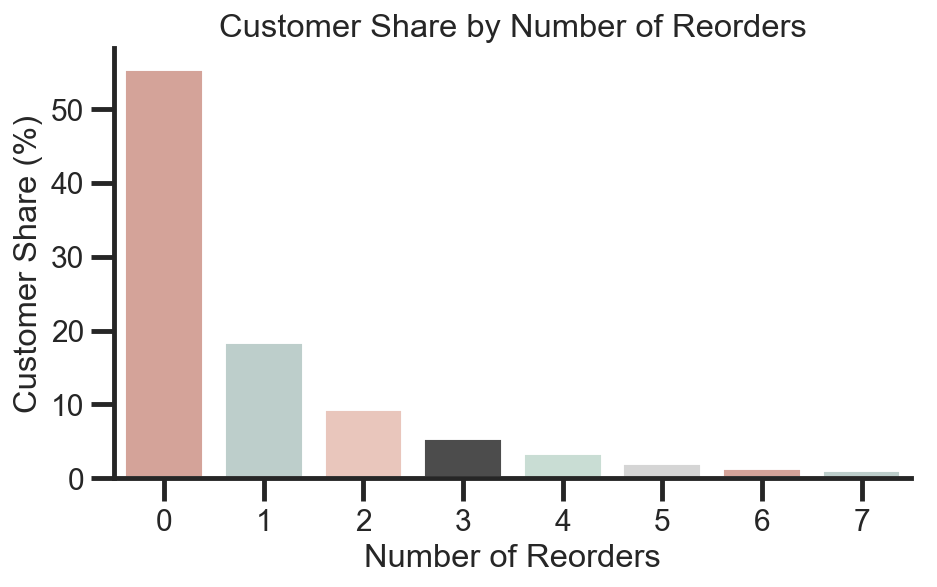

In [11]:
cols = ['recency_cal', 'frequency_cal', 'T_cal', 'monetary_value_cal']
df_rmf = summary_cal_holdout[cols].copy()
df_rmf.columns = ['recency', 'frequency', 'T', 'monetary_value']

frequency = pd.DataFrame(df_rmf.groupby('frequency').size())
frequency = frequency.reset_index()
frequency.columns = ['reorders', 'customers']
frequency['share'] = np.round(100*frequency['customers'] / summary_cal_holdout.shape[0],1)

display(frequency.head(8))

ax = sns.barplot(x="reorders", y="share", data=frequency.head(8), palette=flaconi)
ax.set(xlabel='Number of Reorders', ylabel='Customer Share (%)', title='Customer Share by Number of Reorders')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
sns.despine()
plt.tight_layout()

### Time since last order

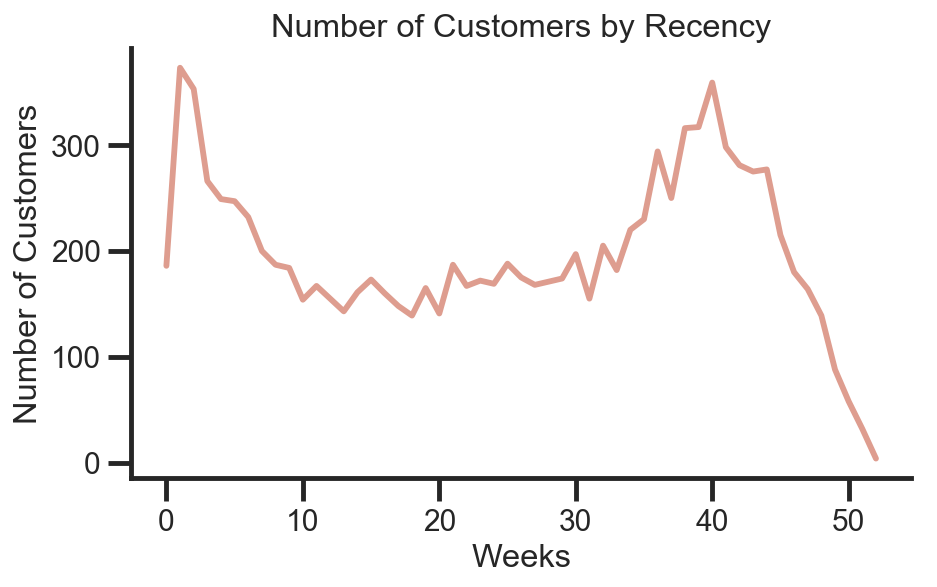

In [12]:
recency = pd.DataFrame(df_rmf.groupby('recency').size())
recency = recency.reset_index()
recency = recency.loc[recency.index > 0]
recency['recency'] = np.round(recency['recency']/7)

recency = pd.DataFrame(recency.groupby('recency').sum())
recency = recency.reset_index()

recency.columns = ['WEEKS', 'CUSTOMER_RETAINED']

ax = sns.lineplot(x='WEEKS', y='CUSTOMER_RETAINED', data=recency)
ax.set(xlabel='Weeks', ylabel='Number of Customers', title='Number of Customers by Recency')
plt.tight_layout()
sns.despine();

In [13]:
recency = pd.DataFrame(df_rmf.groupby(['recency', 'frequency']).size())
recency = recency.reset_index()
#recency = recency.loc[recency.index > 0]
recency['recency'] = np.round(recency['recency']/7)

recency = pd.DataFrame(recency.groupby(['recency', 'frequency']).sum())
recency = recency.reset_index()

recency.columns = ['WEEKS', 'REORDERS', 'CUSTOMER_RETAINED']

recency = recency.loc[recency.REORDERS >= 1]
recency = recency.loc[recency.REORDERS <= 4]

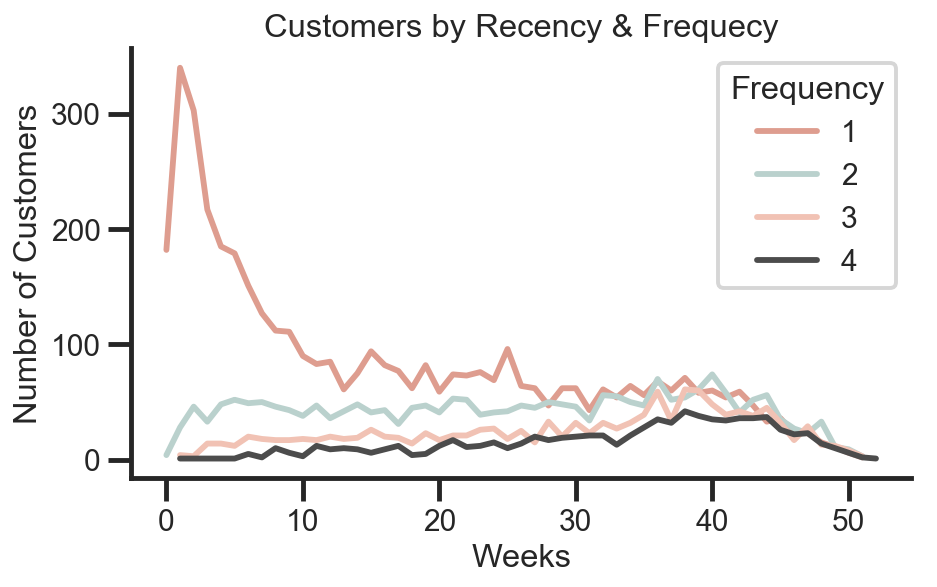

In [14]:
ax = sns.lineplot(x='WEEKS', y='CUSTOMER_RETAINED', hue='REORDERS', data=recency, palette=flaconi[:4])
ax.set(xlabel='Weeks', ylabel='Number of Customers', title='Customers by Recency & Frequecy')

#ax.set_xlim(0, 12)
#ax.set_ylim(1e3, 60e3)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], title="Frequency")
plt.tight_layout()
sns.despine();

In [15]:
rf = pd.DataFrame(df_rmf.groupby(['recency', 'frequency']).size())
rf = rf.reset_index()

rf['recency'] = np.round(rf['recency']/30)
rf['FREQUENCY_BIN'] = np.where(rf['frequency']>= 4, 4, rf['frequency'])
rf['RECENCY_BIN'] = np.where(rf['recency']>= 12, 12, rf['recency'])

rf = pd.DataFrame(rf.groupby(['RECENCY_BIN', 'FREQUENCY_BIN'])[0].sum())
rf = rf.reset_index()

rf.columns = ['RECENCY', 'FREQUENCY', 'CUSTOMERS']

rf = rf[rf.FREQUENCY >0]

### Recency and Frequency Clusters

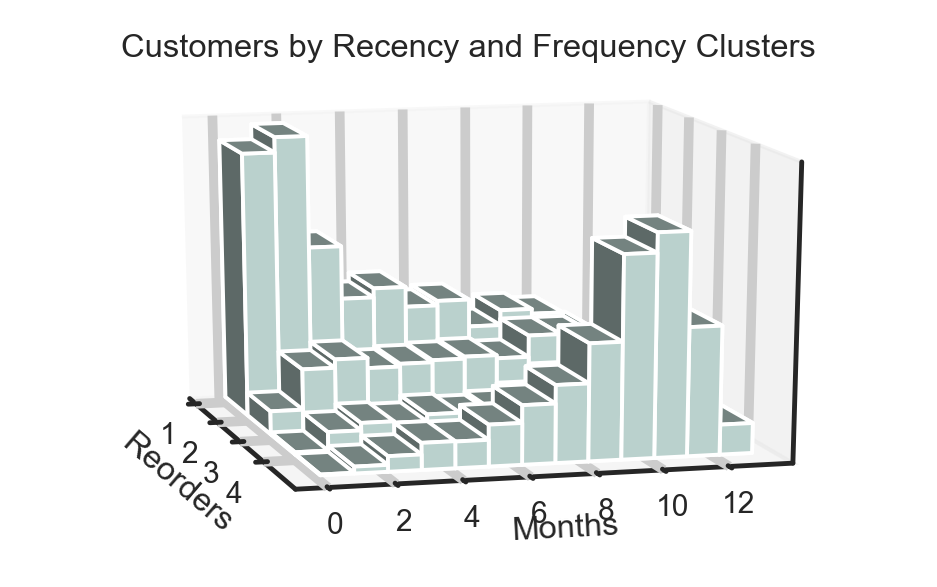

In [16]:
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


# setup the figure and axes
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

# fake data
_y = rf.RECENCY.unique()
_x = rf.FREQUENCY.unique()
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = rf.CUSTOMERS.values
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True, color = '#BAD1CD')
ax1.set_xlabel('Reorders')
ax1.set_ylabel('Months')
ax1.set_title('Customers by Recency and Frequency Clusters')
ax1.set_zlabel('')
ax1.set_zticks([])
ax1.set_xticks([1,2,3,4])
#ax1.set_yticks([0,2,4,6,8,10,12])

ax1.view_init(15, -15)
sns.despine()
plt.tight_layout()
plt.show()

### Average spend per customer

In [17]:
cols = ['monetary_value']
temp = df_rmf[cols].copy()

temp['monetary_value'] = np.round(temp['monetary_value'])
temp = pd.DataFrame(temp.groupby('monetary_value').size())
temp = temp.reset_index()
temp.columns = ['MONETARY_VALUE', 'CUSTOMERS']

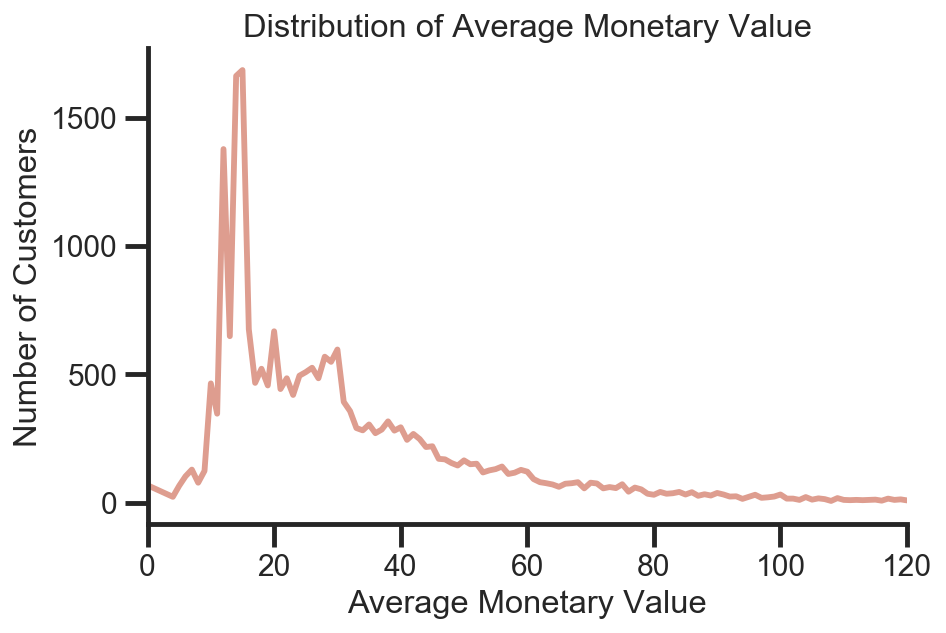

In [18]:
ax = sns.lineplot(x='MONETARY_VALUE', y='CUSTOMERS', data=temp)
ax.set(ylabel='Number of Customers', xlabel='Average Monetary Value', 
       title = 'Distribution of Average Monetary Value')

ax.set_xlim(0, 120)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

sns.despine();

In [19]:
temp['CUMSUM_C'] = temp['CUSTOMERS'].cumsum(axis = 0)
temp['CUMSUM_C'] = 100*temp['CUMSUM_C']/temp['CUMSUM_C'].tail(1).values

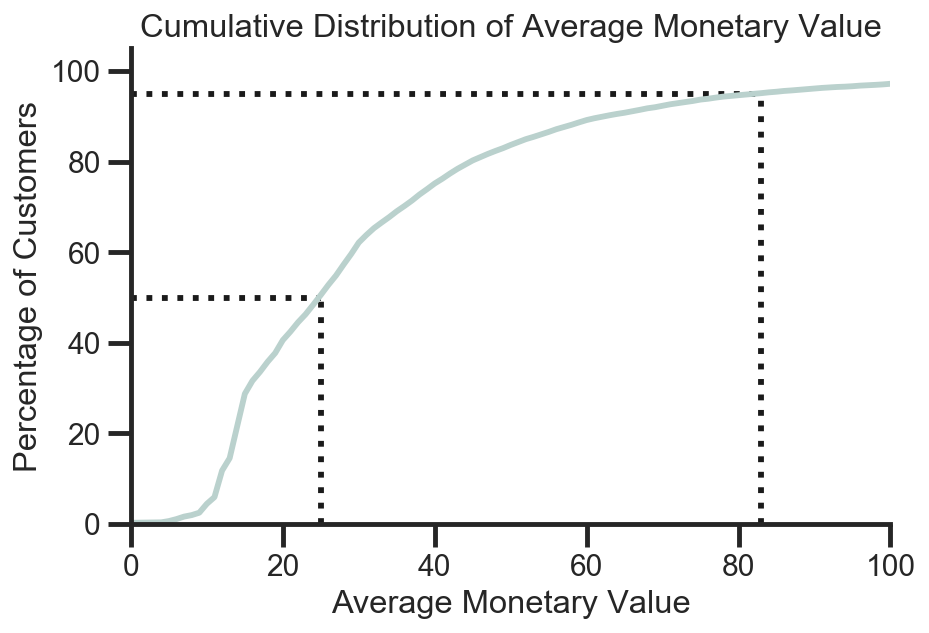

In [20]:
ax = sns.lineplot(x='MONETARY_VALUE', y='CUMSUM_C', data=temp, color='#BAD1CD')
ax.set(xlabel='Average Monetary Value', ylabel='Percentage of Customers',
       title='Cumulative Distribution of Average Monetary Value')

plt.vlines(x=25, ymin=0, ymax=50, linestyles=':')
plt.hlines(y=50, xmin=0, xmax=25, linestyles=':')

plt.vlines(x=83, ymin=0, ymax=95, linestyles=':')
plt.hlines(y=95, xmin=0, xmax=83, linestyles=':')


ax.set_xlim(0, 100)
ax.set_ylim(0, 105)

sns.despine();

In [21]:
cols = ['frequency', 'monetary_value']
temp = df_rmf[cols].copy()

temp['monetary_value'] = np.round(temp['monetary_value'])
temp = temp.loc[temp['frequency'] <=4]

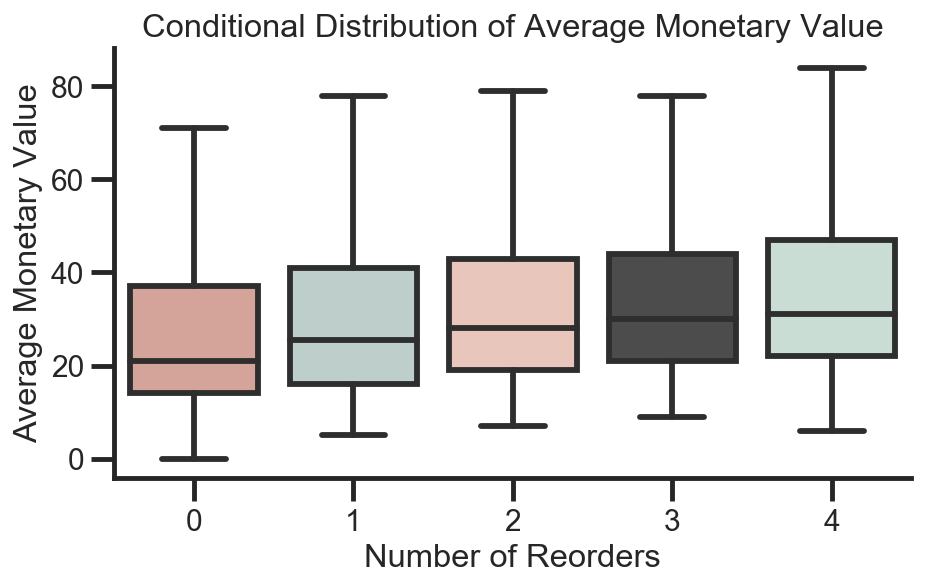

In [22]:
ax = sns.boxplot(x="frequency", y="monetary_value", data=temp, palette=flaconi[:5],
                showfliers=False)
ax.set(xlabel='Number of Reorders', ylabel='Average Monetary Value', 
       title = 'Conditional Distribution of Average Monetary Value')

plt.tight_layout()
sns.despine();